# Actividad: Mejora de modelos usando hiperparametros
## Asignatura: Aprendizaje No supervisado
#### Autor: Jorge Calvo Martín

#### Desarrollo
En esta actividad se ha tomado como base el algoritmo de **Navie Bayes**. Se realizará una mejora de este algoritmo usando una busqueda iterativa de sus hiperparametros y de esta manera conseguir que mejore la eficacia en base a sus valores predeterminados.

Para este estudio de caso se usan dos datasets, lo cuales solo serán entrenados con el 20% de los datos. El algoritmo **Semi-Supervisado** Navie Bayes, tendrá que etiquetar el resto de los datos con la mayor eficacia posible. 

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd
import pandas as pd

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Realizamos la carga de los datos y la separación de las variable y sus etiquetas

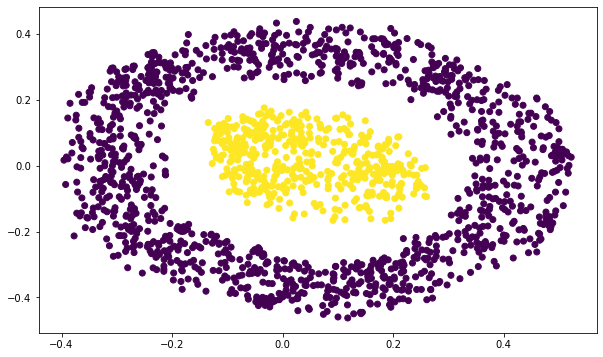

In [2]:
np.random.seed(42) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

#Elección de Datos para la demostración
#data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_inseparable.csv'
data_file_url = 'https://raw.githubusercontent.com/flifuehu/viu-unsupervised-learning/master/datasets/sinteticos/dataset_circulos_concentricos.csv'

D = np.array(pd.read_csv(data_file_url,header=0))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False),:]
Dx = D[:,:2]
Dy = D[:,2]

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(Dx[:,0], Dx[:,1], c = Dy, cmap="viridis")

Separamos los datos para realizar el entrenamiento y el test. Como se ha mencionado en el enunciado superior, unicamente se cogerán el 20% de los datos para entrenar.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(Dx, Dy, train_size=0.2, random_state=42)
print(f"Tamaño de los datos de entrenamiento : {X_train.shape}")
print(f"Tamaño de los datos de test : {X_test.shape}")

Tamaño de los datos de entrenamiento : (347, 2)
Tamaño de los datos de test : (1392, 2)


Para realizar la función del modelo usamos **GaussianNB** al considerar que nuestros datos tienen decimales y asumiendo que siguen una distribución normal.
Una vez que tenemos entrenado el modelo con el 20% de los datos, procedemos a sacar el resto de las etiquetas usando **predict** y finalmente observamos su eficacia al validarlo con las etiquetas reales.

In [10]:
def model_gaussian(X_train,y_train,X_test,y_test):    
    #creación del modelo
    nb_clf = GaussianNB()
    nb_clf.fit(X_train, y_train)

    #Predicciones
    pred_GB=nb_clf.predict(X_test)
    print(f'Accuracy score={metrics.accuracy_score(y_test,pred_GB)}')

    # Matriz de confusión
    plt.figure(figsize=(6,6))
    sns.set()
    sns.heatmap(metrics.confusion_matrix(y_test, pred_GB), annot=True, fmt="d", linewidths=.5)
    plt.title("Matriz de Confusion")

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
    fig.suptitle("Comparación de clasificación GaussianNB")
    ax1.set_title("Reales")
    ax1.scatter(X_test[:,0], X_test[:,1], c = y_test, cmap="viridis")
    ax2.set_title("Predicciones")
    ax2.scatter(X_test[:,0], X_test[:,1], c = pred_GB, cmap="viridis")
    
    return nb_clf

Llamamos a la función y dibujmos su Matriz de Confusión y dos graficas para comparar los datos reales con los predichos.

Accuracy score=0.9454022988505747


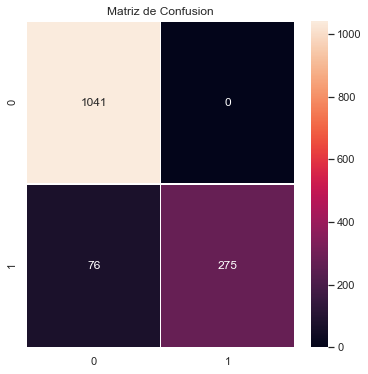

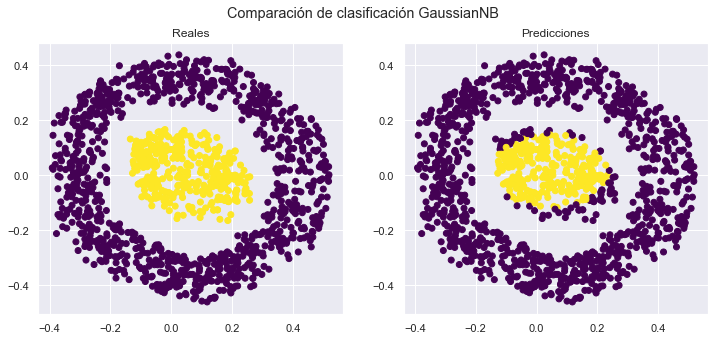

In [11]:
modelo=model_gaussian(X_train,y_train,X_test,y_test)

## Mejora del modelo Gaussian Navie Bayes usando la busqueda de hiperparametros
Debemos conocer que los dos hiperparametros que podemos modificar dentro la instancia **GaussianNB** son:
* **var_smoothing**: Porción más grande de todas las características que se agrega a las variaciones para la estabilidad del cálculo. Es un valor **float**
* **priors**: Probabilidades previas de las clases. Es un array donde el número de elementos es igual a las clases y la suma de todos ellos tiene que dar uno

Creamos una función para generar diferentes **priors** en función al número de clases de nuestro dataset.

In [6]:
def generate_priors(classes):    
    priors=[]
    for _ in range (30):
        t = np.random.random(classes)
        t /=np.sum(t)
        priors.append(list(t))
    return priors

Usamos la instancia **GridSearchCV** para buscar los parametros optimos. Creamos un diccionario donde le pasamos diferentes valores de los parametros anteriormnete mencionados.
Después de validamos con **StratifiedKFold** para ver con cual parametro se obtiene la mayor eficacia

In [7]:
def hyper(X_train,y_train,classes,priors):    
    nb_classifier = GaussianNB()
    
    params_NB = {'var_smoothing': np.logspace(-1,-3, num=30),'priors':priors}
    scores = ['accuracy']
    gs_NB = GridSearchCV(estimator=nb_classifier, 
                     param_grid=params_NB,
                     cv=StratifiedKFold(n_splits=4,  shuffle=True),     
                     scoring='accuracy') 
    gs_NB.fit(X_train, y_train)

    return list(dict(gs_NB.best_params_).values())

In [8]:
def model_gaussian_plus(X_train,y_train,X_test,y_test,smoothing,p):    
    #creación del modelo
    nb_clf = GaussianNB(var_smoothing=smoothing,priors=p)
    nb_clf.fit(X_train, y_train)
  

    #Predicciones
    pred_GB=nb_clf.predict(X_test)
    print(f"Hyperparametros óptimos = {hypervalue}")
    print(f'Accuracy score={metrics.accuracy_score(y_test,pred_GB)}')

    # Matriz de confusión
    plt.figure(figsize=(6,6))
    sns.set()
    sns.heatmap(metrics.confusion_matrix(y_test, pred_GB), annot=True, fmt="d", linewidths=.5)
    plt.title("Matriz de Confusion")

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,5))
    fig.suptitle("Comparación de clasificación GaussianNB")
    ax1.set_title("Reales")
    ax1.scatter(X_test[:,0], X_test[:,1], c = y_test, cmap="viridis")
    ax2.set_title("Predicciones")
    ax2.scatter(X_test[:,0], X_test[:,1], c = pred_GB, cmap="viridis")
    
    return nb_clf

Cuando tenemos los parametros optimos, los pasamos a la función para crear nuestro modelo modificado. el cual obtendra una mejora en los resultados.

Hyperparametros óptimos = [[0.4057433976158405, 0.5942566023841594], 0.0853167852417281]
Accuracy score=0.9935344827586207


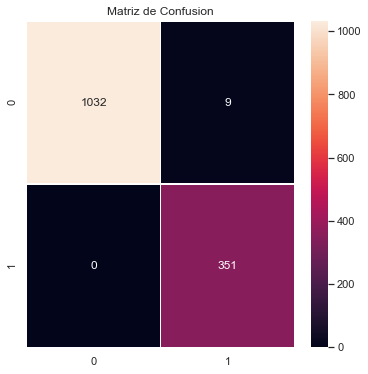

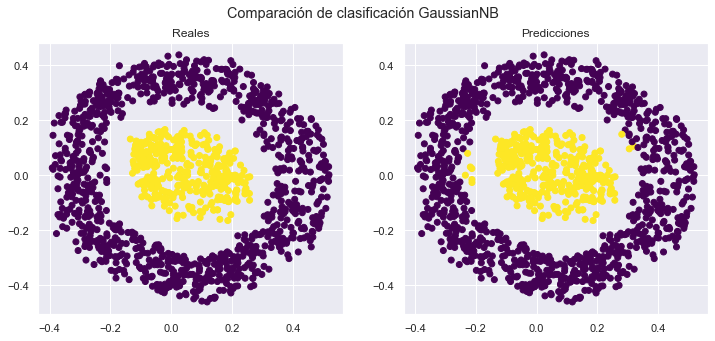

In [9]:
hypervalue=hyper(X_train,y_train,len(np.unique(Dy)),generate_priors(len(np.unique(Dy))))
modelo_plus=model_gaussian_plus(X_train,y_train,X_test,y_test,hypervalue[1],hypervalue[0])